<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно построить модель для прогнозирования количества заказов такси на следующий час.

## Подготовка

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [111]:
import warnings

warnings.filterwarnings('ignore')

Объявим таблицу в переменной data, индексами которой является первая колонка с датами, и преобразуем данные этой колонки к типу datetime64.

In [112]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [114]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Всего в таблице 26496 строк и всего одна колонка с данными о заказах такси. Пропусков в таблице не обнаружено. Проверим рампологаются ли данные в хронологическом порядке.

In [115]:
data.index.is_monotonic

True

Данные расположены в хронологическом порядке, поэтому выполним ресемплирование данных.

In [116]:
data = data.resample('1H').sum()

### Вывод

На этом этапе были загружены и поготовлены данные. Индексами таблицы являются даты соответствующие числу заказов такси и расположены они хронологически верно. Данные были ресемплированы по одному часу

## Анализ

Выведем график заказов такси по времени.

Text(0.5, 1.0, 'Количество заказов такси')

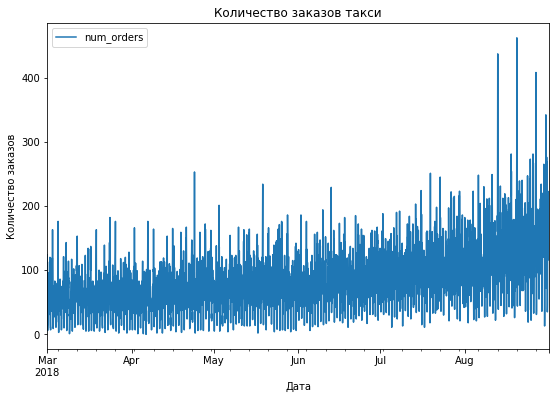

In [117]:
data.plot(figsize=(9, 6))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси')

Получим скальзящее среднее и построим его на этом же графике.

In [118]:
#df = data.resample('1D').mean()
#df.plot(figsize=(9, 6))
#plt.xlabel('Дата')
#plt.ylabel('Количество заказов')
#plt.title('Среднее количество заказов такси в день')

Text(0.5, 1.0, 'Количество заказов такси')

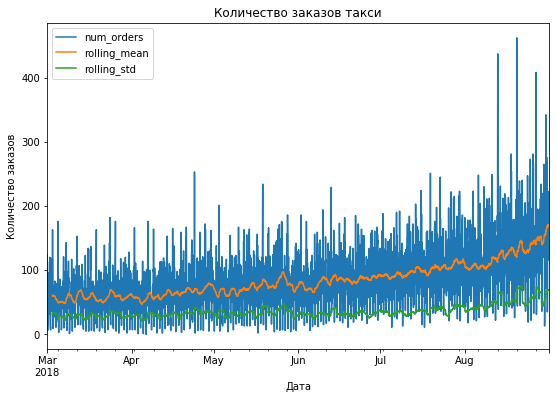

In [119]:
df = data.copy()
df['rolling_mean'] = df['num_orders'].rolling(48).mean()
df['rolling_std'] = df['num_orders'].rolling(48).std()
df.plot(figsize=(9, 6))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси')

Скользящее среднее постепенно растет, скользящее стандартное отклонение почти все время остается постоянным, но с августа тоже начинает расти. Временной ряд не стохастический.

Разобьем данные на тренд, сезонность и остатки и построим их графики.

In [120]:
decomposed = seasonal_decompose(df['num_orders'])

Text(0, 0.5, 'Количество заказов')

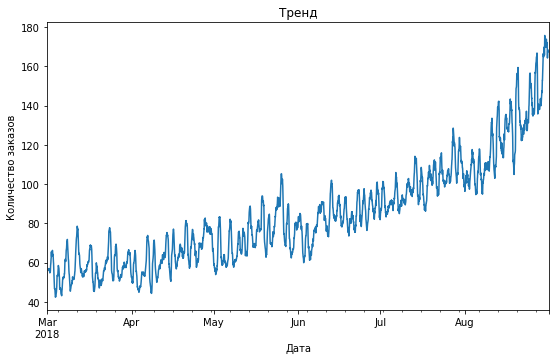

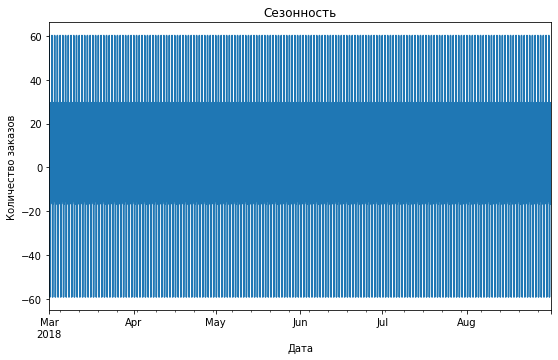

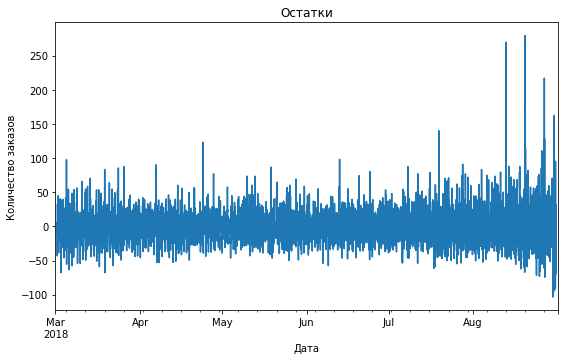

In [121]:
plt.figure(figsize=(9, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.figure(figsize=(9, 18))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.figure(figsize=(9, 18))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

Однозначно можно сказать, что в данных присутствует восходящий тренд, а вот сезонность имеет куда меньший масштаб и требует дальнейшего исстедования. Остатки анализу не поддаются.

Построим график сезонности в масштабе одного месяца.

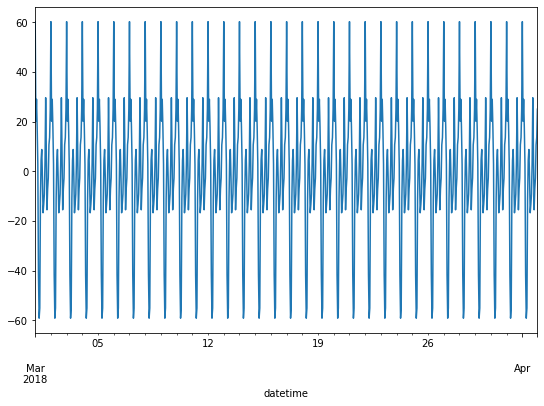

In [122]:
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(figsize=(9, 6))

Построим график сезонности в масштабе одной недели.

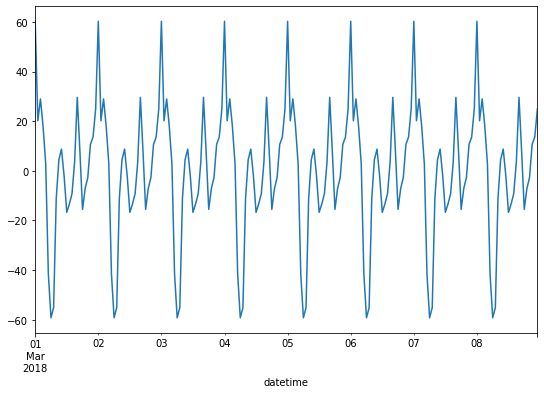

In [123]:
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(figsize=(9, 6))

Построим график сезонности в масштабе одного дня.

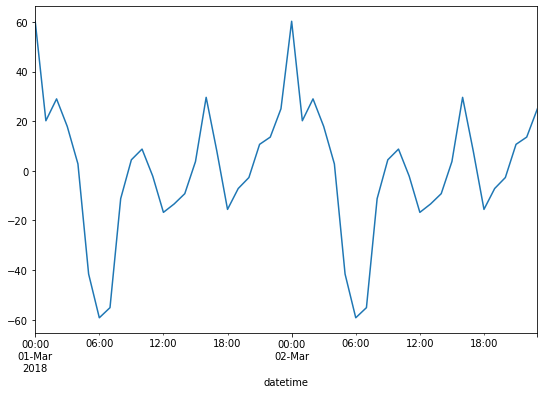

In [124]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(9, 6))

Можно сделать вывод, что пользователи совершают максимальное число заказов такси в полночь и далее число заказов снижается до минимума к раннему утру (6:00), в дальнейшем наблюдается рост до полуночи с локальными точками максимума (10, 15) и минимума (12, 18).

### Вывод

На этом этапе был произведен анализ временного ряда. Было обнаружено, что данные имеют восходящий тренд и сезонность длительностью в один день, с максимальным значением числа заказов такси в полночь и минимальным в 6:00. Так же были однаружены точки локального максимума (10, 15) и минимума (12, 18).

## Обучение

Преред тем как переходить к обучению модели необходимо создать признаки.

In [125]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return data

In [126]:
data = make_features(data, 6, 8)

In [127]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


Удалим строки с пропусками, которые возникли при образовании новых признаков.

In [128]:
print('Количество пропусков:', data['rolling_mean'].isna().sum())
data = data.dropna()
print('Количество пропусков:', data['rolling_mean'].isna().sum())

Количество пропусков: 8
Количество пропусков: 0


In [129]:
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,52.750
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,41.500
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,39.500
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,38.625
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,42.375


Разделим данные на обучающую и тестовую выборки.

In [130]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)

(3967, 12)
(441, 12)


Выведим целевой признак в отдельную переменную.

In [131]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

Напишем скорер RMSE.

In [132]:
def RMSE(target, pred):
    return mean_squared_error(target, pred) ** .5

In [133]:
rmse_scorer = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [134]:
lin = LinearRegression()
rmse_score = abs(
    cross_val_score(lin, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
print('RMSE: {:.2f}'.format(rmse_score))

RMSE: 32.53


### DecisionTree

In [135]:
rnd = 123

In [136]:
depth_best = 0
score_best = 100000
for depth in range(1, 10):
    tree = DecisionTreeRegressor(random_state=rnd, max_depth=depth)
    score = abs(cross_val_score(
        tree, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
        tree_best = tree

print('Глубина:', depth_best)
print('RMSE: {:.2f}'.format(score_best))

Глубина: 8
RMSE: 30.73


### RandomForest

In [137]:
depth_best = 0
score_best = 100000
for depth in range(6, 10):
    forest = RandomForestRegressor(random_state=rnd, n_estimators=10, max_depth=depth)
    score = abs(cross_val_score(
        forest, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
            
print('Глубина:', depth_best)
print('RMSE: {:.2f}'.format(score_best))

Глубина: 9
RMSE: 28.69


In [138]:
score_best = 100000
est_best = 0
for est in range(10, 50, 10):
    forest = RandomForestRegressor(random_state=rnd, n_estimators=est, max_depth=depth_best)
    score = abs(cross_val_score(
        forest, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        score_best = score
        est_best = est
        forest_best = forest

print('Количество деревьев:', est_best)
print('RMSE: {:.2f}'.format(score_best))

Количество деревьев: 40
RMSE: 28.08


### LGBMRegressor

In [139]:
depth_best = 0
score_best = 100000
for depth in range(6, 11):
    lgbm = LGBMRegressor(random_state=rnd, max_depth=depth)
    score = abs(cross_val_score(
        lgbm, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        depth_best = depth
        score_best = score
            
print('Глубина:', depth_best)
print('RMSE: {:.2f}'.format(score_best))

Глубина: 7
RMSE: 27.13


In [140]:
score_best = 100000
est_best = 0
for est in range(100, 300, 50):
    lgbm = LGBMRegressor(random_state=rnd, n_estimators=est, max_depth=depth_best)
    score = abs(cross_val_score(
        lgbm, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        score_best = score
        est_best = est

print('Количество деревьев:', est_best)
print('RMSE: {:.2f}'.format(score_best))

Количество деревьев: 100
RMSE: 27.13


In [141]:
score_best = 100000
rate_best = 0
for rate in np.arange(0.1, 0.6, 0.1):
    lgbm = LGBMRegressor(
        random_state=rnd, n_estimators=est_best, max_depth=depth_best, learning_rate=rate)
    score = abs(cross_val_score(
        lgbm, features_train, target_train, cv=TimeSeriesSplit(), scoring=rmse_scorer).mean())
    if score < score_best:
        score_best = score
        rate_best = rate
        lgbm_best = lgbm

print('Learning rate:', rate_best)
print('RMSE: {:.2f}'.format(score_best))

Learning rate: 0.1
RMSE: 27.13


### Вывод

На этом этапы были созданы новые признаки, удалены прокуски, козникшие при их создании, и произведено обучение модели. На следующем этапе проверим эту модель на тестовых данных.

## Тестирование

Проверим качество модели на тестовых данных.

In [142]:
lgbm_best.fit(features_train, target_train)
predictions = lgbm_best.predict(features_test)
rmse_score = RMSE(target_test, predictions)
print('RMSE: {:.2f}'.format(rmse_score))

RMSE: 43.02


Проверим модель на адекватность, сравнив ее качество с качеством моделей, которые вместо предсказаний дают медиану и предыдущее значение целевого признака.

In [143]:
pred_median = pd.Series(target_train.median(), index=target_test.index)
rmse_score = RMSE(target_test, pred_median)
print('RMSE медианы: {:.2f}'.format(rmse_score))

RMSE медианы: 87.24


In [144]:
pred_previous = target_test.shift(fill_value=target_train.iloc[-1])
rmse_score = RMSE(target_test, pred_previous)
print('RMSE предыдущих значений: {:.2f}'.format(rmse_score))

RMSE предыдущих значений: 58.92


### Вывод

Модель прошла проверку на адекватность и ее качество лучше, чем у грубых моделей.

В проекте были произведены следующие действия:

    - Данные были подготовлены и проверены на монотонность
    - Анализ показал, что в данных присуствует восходящий тренд
    - Также анализ показал сезонность в одну неделю с пиком заказов в полночь и минимумом в 6 утра
    - Были созданы признаки для обучения модели
    - Была обучена модель и проведено ее тестирование и оценка на адекватность.